In [6]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install tensorflow
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [7]:
# Importamos las librerías necesarias
import numpy as np                # NumPy, para el manejo de arrays y operaciones matemáticas de alto nivel
import pandas as pd               # Pandas, para el manejo de datasets en forma de dataframes
import matplotlib.pyplot as plt   # Matplotlib, para la visualización de datos
import tensorflow as tf           # TensorFlow, para la construcción y entrenamiento de modelos de aprendizaje automático

In [8]:
# Leemos los datos del archivo CSV y lo cargamos en un dataframe de Pandas
df = pd.read_csv("DOM_hourly.csv",
                 index_col='Datetime',   # Definimos 'Datetime' como el índice del dataframe
                 parse_dates=True)       # Interpretamos las fechas de forma adecuada

# Muestra las primeras 5 filas del dataframe
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [9]:
# Muestra información acerca del dataframe incluyendo el índice dtype y column dtypes, valores no-nulos y uso de memoria
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116189 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DOM_MW  116189 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [10]:
# Genera estadísticas descriptivas que resumen la tendencia central, dispersión y forma de la distribución del dataframe
df.describe()

,DOM_MW
count,116189.000000
mean,10949.203625
std,2413.946569
min,1253.000000
25%,9322.000000
50%,10501.000000
75%,12378.000000
max,21651.000000


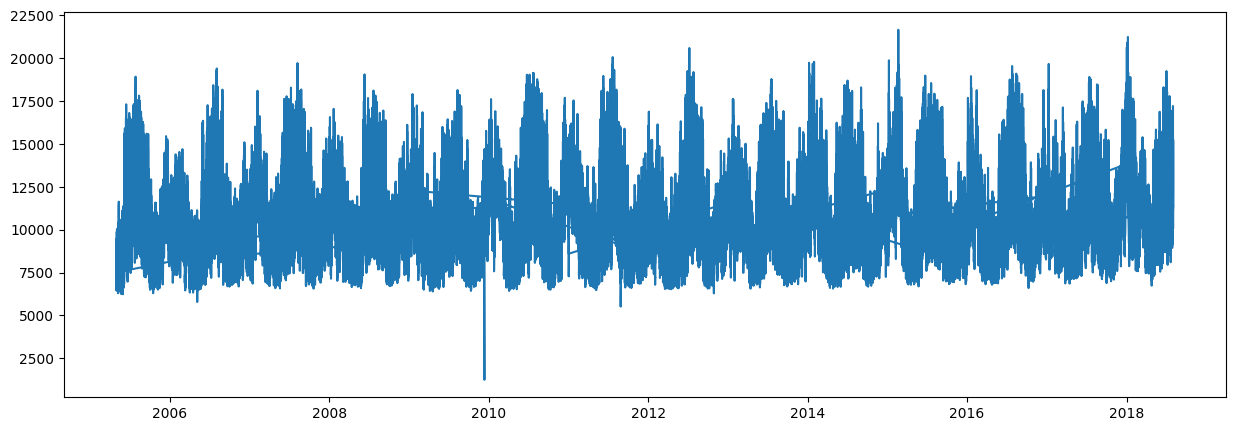

In [11]:
# Visualizamos el dataframe
fig = plt.figure(figsize=(15, 5)) # Definimos el tamaño de la figura
plt.plot(df)                      # Hacemos un gráfico lineal del dataframe
plt.show()                        # Mostramos la figura

In [12]:
# Vemos las dimensiones del array después de redimensionarlo a una matriz de una sola columna
df['DOM_MW'].values.reshape(-1, 1).shape

(116189, 1)

In [15]:
# Importamos la clase MinMaxScaler de sklearn para normalizar nuestros datos
from sklearn.preprocessing import MinMaxScaler

def normalizar_data(df):
  scaler = MinMaxScaler()                      # Creamos un objeto MinMaxScaler
  df['DOM_MW'] = scaler.fit_transform(df['DOM_MW'].values.reshape(-1, 1)) # Normalizamos la columna 'DOM_MW'
  return df

# Normalizamos el dataframe y vemos sus dimensiones
df_normalizado = normalizar_data(df)
df_normalizado.shape

(116189, 1)

In [16]:
# Mostramos el dataframe normalizado
df_normalizado

,DOM_MW
Datetime,
2005-12-31 01:00:00,0.398863
2005-12-31 02:00:00,0.383224
2005-12-31 03:00:00,0.379841
2005-12-31 04:00:00,0.381851
2005-12-31 05:00:00,0.386263
...,...
2018-01-01 20:00:00,0.841504
2018-01-01 21:00:00,0.848809
2018-01-01 22:00:00,0.836062


In [17]:
# Definimos una función para preparar nuestros datos para el entrenamiento
def carga_datos(datos, tamano_bloque) :
  X_train = []  # Crear una lista vacía para los datos de entrenamiento
  y_train = []  # Crear una lista vacía para las etiquetas de entrenamiento

  # Dividimos los datos en bloques de tamaño tamano_bloque
  for i in range(tamano_bloque, len(datos)) :
    X_train.append(datos.iloc[i - tamano_bloque: i, 0])
    y_train.append(datos.iloc[i, 0])

  # Separamos los datos de entrenamiento y de prueba
  X_test = X_train[110000:]
  y_test = y_train[110000:]

  X_train = X_train[:110000]
  y_train = y_train[:110000]

  # Convertimos las listas en arrays de numpy
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  # Redimensionamos los datos para cumplir con la entrada requerida por LSTM en Keras
  X_train = np.reshape(X_train, (110000, tamano_bloque, 1))
  X_test = np.reshape(X_test, (X_test.shape[0], tamano_bloque, 1))

  return [X_train, y_train, X_test, y_test]

In [18]:
# Ejemplos de la forma que tienen los arrays y los tensores en numpy
np.array([1,2,3,4,5]).shape                       # Un array unidimensional
np.array([[1,2,3,4,5],[6,7,8,9,0]]).shape         # Un array bidimensional (una matriz)
np.array([[[1,2,3,4,5],[6,7,8,9,10]],[[11,12,13,14,15],[16,17,18,19,20]]]).shape # Un tensor tridimensional

(2, 2, 5)

In [19]:
# Definimos el tamaño del bloque para los datos que se utilizarán en el modelo
tamano_bloque = 20

# Utilizamos la función carga_datos definida anteriormente para preparar nuestros datos
X_train, y_train, X_test, y_test = carga_datos(df_normalizado, 20)

# Imprimimos la forma de cada conjunto de datos
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (110000, 20, 1)
y_train.shape: (110000,)
X_test.shape: (6169, 20, 1)
y_test.shape: (6169,)


In [20]:
# Importamos las clases y funciones necesarias de Keras para construir nuestro modelo
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential

# Creamos un modelo secuencial
modelo = Sequential()

# Agregamos una capa LSTM con 40 unidades, activación 'tanh' y con retorno de secuencias
modelo.add(SimpleRNN(40, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1],1)))

# Agregamos una capa de Dropout para evitar el sobreajuste
modelo.add(Dropout(0.20))

# Agregamos una capa SimpleRNN con 40 unidades, activación 'tanh' y con retorno de secuencias
modelo.add(SimpleRNN(40, activation='tanh', return_sequences=True))
modelo.add(Dropout(0.20))

# Agregamos otra capa LSTM con 40 unidades, activación 'tanh' y con retorno de secuencias
modelo.add(SimpleRNN(40, activation='tanh', return_sequences=True))
modelo.add(Dropout(0.20))

# Agregamos otra capa SimpleRNN con 40 unidades, activación 'tanh' y sin retorno de secuencias
modelo.add(SimpleRNN(40, activation='tanh', return_sequences=False))
modelo.add(Dropout(0.20))

# Agregamos una capa Dense con 1 neurona que dará la salida del modelo
modelo.add(Dense(1))

# Imprimimos un resumen del modelo
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_2 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 40)                3

In [21]:
# Compilamos el modelo usando el optimizador Adam y la pérdida de error cuadrático medio
modelo.compile(optimizer="adam", loss="MSE")

# Entrenamos el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train, epochs=10, batch_size=40)

2750/2750 [==============================] - 28s 9ms/step - loss: 0.0179


In [22]:
# Importamos las métricas de scikit-learn para evaluar el rendimiento del modelo
from sklearn.metrics import r2_score, mean_squared_error

# Hacemos la predicción con los datos de prueba
y_pred = modelo.predict(X_test)

# Aplanamos los arrays para calcular las métricas
y_test_2d = y_test.flatten()
y_pred_2d = y_pred.flatten()

# Calculamos el coeficiente de determinación (R^2) y la raíz del error cuadrático medio (RMSE)
score_r2 = r2_score(y_test_2d, y_pred_2d)
rmse_score = np.sqrt(mean_squared_error(y_test_2d, y_pred_2d))

print("Score R2", score_r2)
print("RMSE", rmse_score)

193/193 [==============================] - 1s 3ms/step
Score R2 0.9207421021002964
RMSE 0.03465389050216927
